In [2]:
import numpy as np
import plotly.express as px
from scipy import stats, optimize

In [31]:
objects = [
    {"x": -12, "y": 12, "r": 4, "spin": 20}
]

radar_x = 3
radar_y = 4

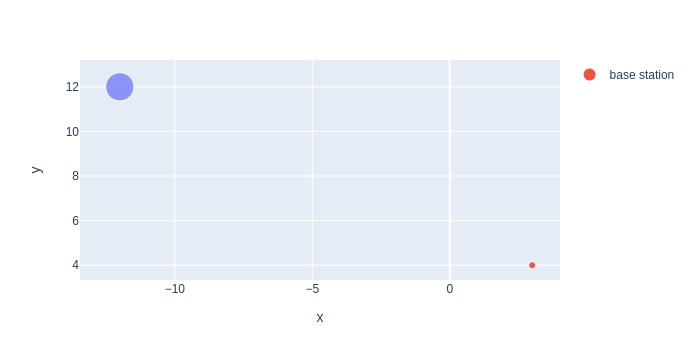

In [32]:
fig = px.scatter(
    x = [o["x"] for o in objects],
    y = [o["y"] for o in objects],
    size = [o["r"] for o in objects],
)
fig.add_scatter(x=[radar_x], y=[radar_y], mode="markers", name="base station")
fig.show()

In [35]:
num_angles = 2000
point_xs = []
point_ys = []
point_vs = []
point_angles = []

for angle in np.linspace(0, 2*np.pi, num_angles):
    Dx = np.cos(angle)
    Dy = np.sin(angle)
    hit = None
    min_t = float("inf")
    for obj in objects:
        # Look ray from radar to object
        Lx = obj["x"] - radar_x
        Ly = obj["y"] - radar_y
        tca = Dx*Lx + Dy*Ly
        if tca < 0:
            continue
        try:
            d = np.sqrt(Lx*Lx+Ly*Ly - tca*tca)
            thc = np.sqrt(obj["r"]*obj["r"] - d*d)
        except:
            # imaginary root
            continue
        
        # ray hit distance
        t = min(tca+thc, tca-thc)
        
        # if hit distance is the smallest so far (ie. forward object shadows rear object)
        if t < min_t:
            # hit pos
            hx = radar_x + Dx * t
            hy = radar_y + Dy * t
            
            # Calculate velocity in the direction of the radar (TODO maybe wrong)
            hit_angle = np.arctan2(hx - obj["x"], hy-obj["y"])
            incident_angle = np.arctan2(radar_x - obj["x"], radar_y - obj["y"])
            # Find difference between incident angle and hit angle (without wrapping artifacts)
            # functionally same as d_angle = hit_angle - incident_angle
            d_angle = np.arctan2(
                np.sin(hit_angle - incident_angle), 
                np.cos(hit_angle - incident_angle)
            )
            velo = obj["spin"] * np.sin(d_angle)
            
            # add noise to hit pos
            hx_noise = hx + np.random.normal(scale=0.2)
            hy_noise = hy + np.random.normal(scale=0.2)
            # store hit
            hit = (hx_noise, hy_noise, velo, angle)
            # store min hit distance at this angle
            min_t = t
    if hit is not None:
        point_xs.append(hit[0])
        point_ys.append(hit[1])
        point_vs.append(hit[2])
        point_angles.append(hit[3])

# x pos
point_xs = np.array(point_xs)
# y pos
point_ys = np.array(point_ys)
# velocity in direction of radar (proportional to doppler shift)
point_vs = np.array(point_vs)
# angle that the radar is facing when it collected this point
point_angles = np.array(point_angles)

/tmp/ipykernel_50808/4176878701.py:21: RuntimeWarning:

invalid value encountered in sqrt



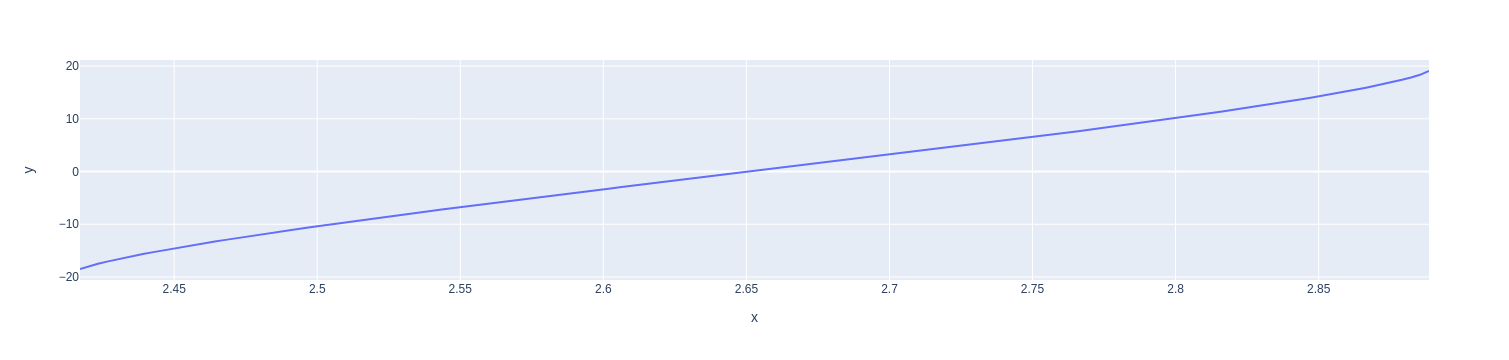

In [36]:
fig = px.line(x=point_angles, y=point_vs)
fig.show()

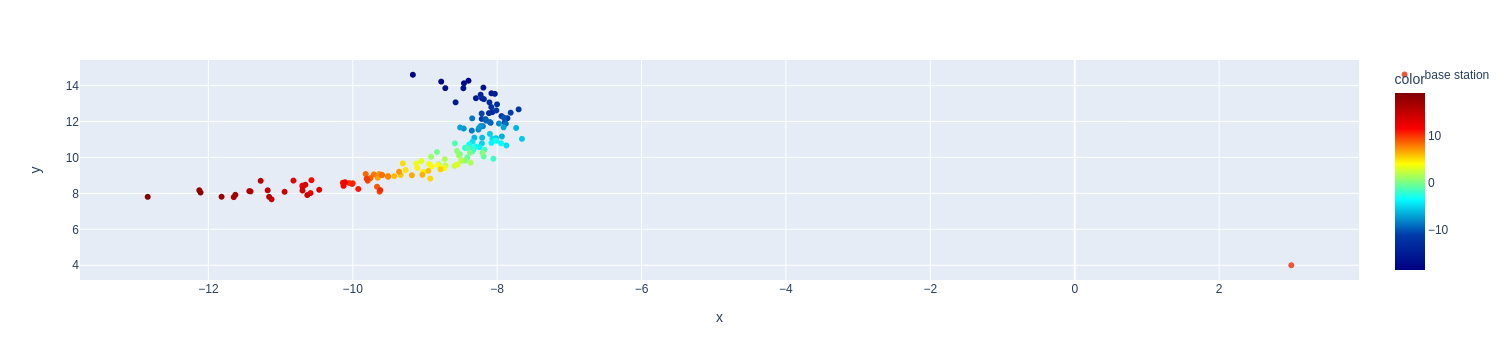

In [37]:
fig = px.scatter(x=point_xs, y=point_ys, color=point_vs, color_continuous_scale="Jet")
fig.add_scatter(x=[radar_x], y=[radar_y], mode="markers", name="base station")

fig.show()

## estimation of circle parameters
See: [construction shit](https://www.iaarc.org/publications/fulltext/S17-2.pdf)

it converges for suitably close initial guesses, but fucks out with other ones (local minimum?)

In [60]:
def generate_likelihood_fn_1(xs, ys):
    def likelihood_fn(params):
        a, b = params[0], params[1]
        r = 1
        
        s = 0
        for xa, ya in zip(xs, ys):
            num = np.square(xa*xa + ya*ya - 2*a*xa - 2*b*ya + a*a + b*b - r*r)
            den = xa*xa + ya*ya - 2*a*xa - 2*b*ya + a*a + b*b
            s += num / den
        return s
    return likelihood_fn

In [61]:
# guess = np.array([0, 0])
opt_res = optimize.minimize(
    generate_likelihood_fn_1(point_xs, point_ys),
    guess,
    options={"disp": True, "maxiter": 100}
)

Optimization terminated successfully.
         Current function value: 123.602007
         Iterations: 13
         Function evaluations: 51
         Gradient evaluations: 17


In [62]:
opt_res

      fun: 123.60200660608156
 hess_inv: array([[ 0.00124558, -0.001341  ],
       [-0.001341  ,  0.00320729]])
      jac: array([-2.86102295e-06, -2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 13
     njev: 17
   status: 0
  success: True
        x: array([3.62068653, 4.2986378 ])

## Circle parameter estimation v2
See [deep state paper](https://ieeexplore-ieee-org.ezproxy.canterbury.ac.nz/stamp/stamp.jsp?tp=&arnumber=1608136)

### Why cirlce parameter estimation is bad
- Log-liklihood function contains many local minima
- LL function contains plateaus of low gradient -> slow conergence
- See [Least squares fitting of circles and lines](https://people.cas.uab.edu/~mosya/papers/cl1.pdf) for why its hard

In [122]:
def gen_log_likelihood(x_values, y_values):
    def likelihood_fn(params):
        cx, cy, r = params[0], params[1], params[2]
        
        norm = np.sqrt(np.square(x_values - cx) + np.square(y_values - cy))
        return np.sum(np.square(norm - r))
    return likelihood_fn

In [123]:
closest_idx = np.argmin(
    np.sqrt(
        np.square(point_xs - radar_x) +
        np.square(point_ys - radar_y)
    )
)
guess = np.array([point_xs[closest_idx], point_ys[closest_idx], 1.0])

In [124]:
guess_x = np.mean(point_xs)
guess_y = np.mean(point_ys)
guess = np.array([guess_x, guess_y, 1.0])
guess

array([-8.97547945, 10.37422981,  1.        ])

In [125]:
opt_res = optimize.minimize(
    gen_log_likelihood(point_xs, point_ys),
    guess,
    options={"disp": True}
)
opt_res

Optimization terminated successfully.
         Current function value: 3.210200
         Iterations: 14
         Function evaluations: 72
         Gradient evaluations: 18


      fun: 3.210200189545908
 hess_inv: array([[ 0.18765616, -0.08228818, -0.17427514],
       [-0.08228818,  0.07024505,  0.09000532],
       [-0.17427514,  0.09000532,  0.17398394]])
      jac: array([1.31130219e-06, 8.64267349e-07, 4.55975533e-06])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 14
     njev: 18
   status: 0
  success: True
        x: array([-12.02272778,  11.98778844,   4.02000347])

## Better circle fitting algos
[paper](https://people.cas.uab.edu/~mosya/papers/cl1.pdf)